## 少ない特徴量でユーザー×オークション予測

In [1]:
from os.path import dirname
import os
import datetime
from dateutil.relativedelta import relativedelta
import pathlib
import re
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [2]:
pd.set_option('display.max_columns', 50)

In [3]:
%reload_ext autoreload
from brandear_est import utils, dataset as bds, models, evals as ev, submit
from brandear_est.preprocess import pp_est_rank_weekly as pp

In [4]:
SUB_DIR = os.path.join(os.getcwd(), "../../data/submit")
IMD_DIR = os.path.join(os.getcwd(), "../../data/intermediate/")
INPUT_DIR = os.path.join(os.getcwd(), "../../data/input")

IMD_INPUT_DIR = os.path.join(IMD_DIR, "pickled_inputs")
IMD_RANK_WEEKLY_DIR = os.path.join(IMD_DIR, "rank_weekly")
IMD_ARCHIVE_DIR = os.path.join(IMD_DIR, "arc_rank_weekly")
IMD_VALID_AUCS_DIR = os.path.join(IMD_DIR, "valid_aucs")

dset_to_period = {
    "train": {"oldest": datetime.datetime(2019, 9, 3, 0, 0, 0),
              "newest": datetime.datetime(2019, 9, 10, 0, 0, 0)},
    "valid_for_train": {"oldest": datetime.datetime(2019, 9, 10, 0, 0, 0),
              "newest": datetime.datetime(2019, 9, 17, 0, 0, 0),},    
    "valid_for_sub": {"oldest": datetime.datetime(2019, 9, 17, 0, 0, 0),
              "newest": datetime.datetime(2019, 9, 24, 0, 0, 0),},
    "submission": {"oldest": datetime.datetime(2019, 9, 24, 0, 0, 0),
              "newest": datetime.datetime(2019, 10, 1, 0, 0, 0),},    
}

## インプットデータ整理

In [5]:
# 元データ読み込み
auction = pd.read_pickle(os.path.join(IMD_INPUT_DIR , "auction.pkl"))
watch = pd.read_pickle(os.path.join(IMD_INPUT_DIR , "watch.pkl"))
bid = pd.read_pickle(os.path.join(IMD_INPUT_DIR , "bid.pkl"))
bid_success = pd.read_pickle(os.path.join(IMD_INPUT_DIR , "bid_success.pkl"))
sample_sub = pd.read_csv(os.path.join(os.getcwd(), "../../data/input" , "sample_submission.csv"))
sub_users = sample_sub[["KaiinID"]].drop_duplicates()

# ブランド作成日
brand = utils.read_csv(os.path.join(INPUT_DIR , "brand.csv"))
# itemcolorid付与(色の大分類)
color = utils.read_csv(os.path.join(INPUT_DIR , "color.csv"))
# カテゴリーid,itemdailID付与のためのItemShouID付与
genre = utils.read_csv(os.path.join(INPUT_DIR , "genre.csv"))
# itemshowID,itemdailID付与
itemshou = utils.read_csv(os.path.join(INPUT_DIR , "itemshou.csv"))
# itemlineID付与
line = utils.read_csv(os.path.join(INPUT_DIR , "line.csv"))

# オークション情報拡充
auction_mst = pp.build_auction_mst(
    auction=auction, itemshou=itemshou, genre=genre,
    brand=brand, color=color, line=line
)

Mem. usage decreased to  0.32 Mb (15.0% reduction)
Mem. usage decreased to  0.01 Mb (32.2% reduction)
Mem. usage decreased to  0.00 Mb (45.4% reduction)
Mem. usage decreased to  0.00 Mb (33.4% reduction)
Mem. usage decreased to  0.01 Mb (41.3% reduction)


## 特徴量エンジニアリング

In [7]:
# tr_dataset_input = pd.read_pickle(IMD_VALID_AUCS_DIR + "/train.pkl")
vt_dataset_input = pd.read_pickle(IMD_VALID_AUCS_DIR + "/valid_for_train.pkl")
vs_dataset_input = pd.read_pickle(IMD_VALID_AUCS_DIR + "/valid_for_sub.pkl")
# sub_dataset_input = pd.read_pickle(IMD_VALID_AUCS_DIR + "/submission.pkl")

In [9]:
# %%time

auc_attr_col = [
    "AuctionID", "ShouhinID", "BrandID", "ItemShouID",
    "SaishuppinKaisuu", "SankouKakaku", "1m_watch_AuctionID_cnt", "1m_watch_ShouhinID_cnt", "1m_watch_ItemShouID_cnt",
    "elapsed_days", "watch_elapsed_days"
]

dataset_inputs = {
#     "train": watch_train_dataset,
    "valid_for_train": vt_dataset_input,
    "valid_for_sub": vs_dataset_input
#     "submission": sub_dataset_input
}
valid_auc_th = 0.15

data_dict = {"watch": watch, "bid": bid, "bid_success": bid_success, "auction": auction_mst}

pp.build_target_candidate(
    dataset_inputs=dataset_inputs,
    valid_auc_th=valid_auc_th,
    auc_attr_col=auc_attr_col,
    data_dict=data_dict,
    dset_to_period=dset_to_period,
    output_path=IMD_ARCHIVE_DIR
)

valid_for_train 分割 0 番目


/Users/nobuyuki.ishida/Practice/competition/nishika/Brandear/code/brandear_est/brandear_est/utils.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["cross_flg"] = 0


valid_for_train 分割 1 番目


KeyboardInterrupt: 

## 予測

In [21]:
drop_cols = ["KaiinID", "AuctionID", "bid_actioned", "watch_actioned"]
target_col="watch_actioned"

vs_dataset_input = utils.read_comp_pkl(IMD_DIR + "valid_for_sub_pred/split_cands_8.pkl").drop_duplicates()
vs_dataset = bds.DataSet(data=vs_dataset_input.sample(frac=0.05),drop_cols=drop_cols, target_col="watch_actioned")

In [29]:
%%time
## 予測

dset_pairs = [
    {"old": "valid_for_train", "new": "valid_for_sub_pred"}
]
for dset_pair in dset_pairs:

    paths = (
        sorted([p for p in pathlib.Path(IMD_DIR + "/" + dset_pair['old']).iterdir()
               if os.path.basename(p) != ".DS_Store"])[:2]
    )
    df_buf = []
    for path in paths:
        print(path)
        with open(path, mode="rb") as f:
            tmp_df = joblib.load(f).drop_duplicates()
#             tmp_df = joblib.load(f)
        df_buf.append(
            tmp_df.query("(watch_actioned == 1) | (bid_actioned == 1)").sample(frac=1, random_state=1).groupby("KaiinID").head(4)
        )
        df_buf.append(
            tmp_df.query("(watch_actioned != 1) & (bid_actioned != 1)").sample(frac=0.01, random_state=1).groupby("KaiinID").head(200)
        )
    dataset_input = pd.concat(df_buf)

    drop_cols = ["KaiinID", "AuctionID", "bid_actioned", "watch_actioned"]
    vt_dataset = bds.DataSet(data=dataset_input,drop_cols=drop_cols, target_col="watch_actioned")
    lgb_bi = models.LgbBinaryClassifier()
    lgb_bi.train(train_dataset=vt_dataset, valid_dataset=vs_dataset, desc=True)    

    for i, path in enumerate(pathlib.Path(IMD_DIR + "/" + dset_pair["new"]).iterdir()):
        if os.path.basename(path) == ".DS_Store": continue
        print(i)
        if i > 10: break
        sub_dataset = bds.DataSet(data=utils.read_comp_pkl(path), drop_cols=drop_cols, target_col=target_col)        
        pred = lgb_bi.predict(sub_dataset)
        sub_dataset.set_pred(pred)
        
#         df2comp_pkl(sub_dataset.data, IMD_ARCHIVE_DIR + f"/{dset_pair['new']}_pred/", os.path.basename(path)) 
#         os.remove(path)

/Users/nobuyuki.ishida/Practice/competition/nishika/Brandear/code/brandear_est/../../data/intermediate/valid_for_train/split_cands_0.pkl
/Users/nobuyuki.ishida/Practice/competition/nishika/Brandear/code/brandear_est/../../data/intermediate/valid_for_train/split_cands_1.pkl
[1]	valid_0's auc: 0.857801
[2]	valid_0's auc: 0.847833
[3]	valid_0's auc: 0.846027
[4]	valid_0's auc: 0.860122
[5]	valid_0's auc: 0.848011
[6]	valid_0's auc: 0.859668
[7]	valid_0's auc: 0.859978
[8]	valid_0's auc: 0.859849
[9]	valid_0's auc: 0.865994
[10]	valid_0's auc: 0.86604
[11]	valid_0's auc: 0.871382
[12]	valid_0's auc: 0.87055
[13]	valid_0's auc: 0.864016
[14]	valid_0's auc: 0.8635
[15]	valid_0's auc: 0.861535
[16]	valid_0's auc: 0.861913
[17]	valid_0's auc: 0.862289
[18]	valid_0's auc: 0.862226
[19]	valid_0's auc: 0.862338
[20]	valid_0's auc: 0.876537
[21]	valid_0's auc: 0.876018
[22]	valid_0's auc: 0.870662
[23]	valid_0's auc: 0.872092
[24]	valid_0's auc: 0.869252
[25]	valid_0's auc: 0.86484
[26]	valid_0's 

KeyboardInterrupt: 

In [32]:
%%time
## 予測値上位の候補を出力
target_col = "watch_actioned"
th = 1600
dset_types = ["valid_for_sub"]
for dset_type in dset_types:
    choiced_cands_buf = []    
    for i, path in enumerate(pathlib.Path(IMD_DIR + f"/{dset_type}_pred/").iterdir()):
        print(path)
        if os.path.basename(path) == ".DS_Store": continue
        splited_action_cands = (
            utils.read_comp_pkl(path)
            .sort_values(['KaiinID', 'pred'], ascending=[True, False])
        )
        splited_action_cands['rank'] = splited_action_cands.groupby('KaiinID')['pred'].cumcount()        
        choiced_cands = splited_action_cands.query(f"rank <= {th}")
        choiced_cands_buf.append(choiced_cands)

#     be.df2pkl(pd.concat(choiced_cands_buf), IMD_RANK_WEEKLY_DIR, f"{dset_type}_{th}_tmp.pkl")

/Users/nobuyuki.ishida/Practice/competition/nishika/Brandear/code/brandear_est/../../data/intermediate/valid_for_sub_pred/split_cands_17.pkl
/Users/nobuyuki.ishida/Practice/competition/nishika/Brandear/code/brandear_est/../../data/intermediate/valid_for_sub_pred/split_cands_16.pkl


KeyboardInterrupt: 

## 予測結果可視化

### 正解データ、非正解データそれぞれの予測値分布

(array([9.911167e+06, 4.205730e+05, 2.220470e+05, 1.274280e+05,
        7.375700e+04, 5.271800e+04, 4.388500e+04, 4.086600e+04,
        3.931600e+04, 3.230300e+04, 2.536700e+04, 2.080000e+04,
        1.779000e+04, 1.363800e+04, 1.268500e+04, 9.641000e+03,
        9.527000e+03, 8.180000e+03, 8.345000e+03, 7.704000e+03,
        6.619000e+03, 5.259000e+03, 4.504000e+03, 4.249000e+03,
        3.324000e+03, 3.313000e+03, 2.499000e+03, 2.283000e+03,
        2.402000e+03, 1.863000e+03, 2.449000e+03, 1.711000e+03,
        1.533000e+03, 1.488000e+03, 1.396000e+03, 1.299000e+03,
        1.044000e+03, 1.103000e+03, 1.222000e+03, 1.219000e+03,
        1.035000e+03, 9.330000e+02, 7.670000e+02, 7.790000e+02,
        6.990000e+02, 6.720000e+02, 6.550000e+02, 9.190000e+02,
        7.650000e+02, 6.640000e+02, 6.700000e+02, 5.080000e+02,
        5.880000e+02, 4.340000e+02, 3.860000e+02, 4.410000e+02,
        4.190000e+02, 4.450000e+02, 3.300000e+02, 2.800000e+02,
        2.670000e+02, 3.730000e+02, 2.16

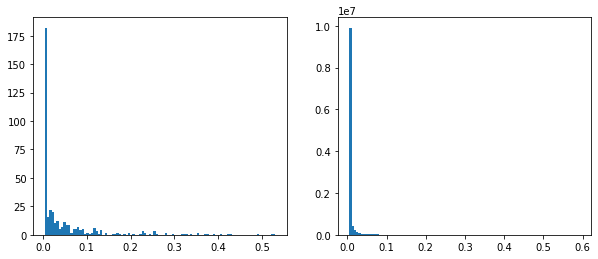

In [34]:
tmp = utils.read_comp_pkl(IMD_DIR + f"/{dset_pair['new']}/split_cands_1.pkl")

fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
axL.hist(tmp.query(f"watch_actioned == 1").pred, bins=100)
axR.hist(tmp.query(f"watch_actioned != 1").pred, bins=100)

### 残ったデータでどのくらいのndcgスコアが出せるか

In [44]:
%reload_ext autoreload
from brandear_est import utils, dataset as bds, models, evals as ev, submit
from brandear_est.preprocess import pp_est_rank_weekly as pp

In [6]:
tmp = pd.read_pickle(IMD_RANK_WEEKLY_DIR + "/valid_for_sub_1600.pkl")[["AuctionID", "KaiinID"]].drop_duplicates()

dset_type = "valid_for_sub"

watch_arranged, bid_arranged, bid_success_arranged, auction_arranged, target_actions = (
    pp.arrange_inputs(watch=watch, bid=bid, bid_success=bid_success, auction=auction_mst, period=dset_to_period[dset_type])
)

tmp_sim = pp.extract_similar_aucs(
    target_users=tmp[["KaiinID"]].drop_duplicates(),
    auction=auction_arranged,
    actions=pd.concat([watch_arranged, bid_arranged])[["KaiinID", "ShouhinID"]],
    period=dset_to_period[dset_type]
)[["AuctionID", "KaiinID"]].drop_duplicates()

cheat_pred = submit.get_cheat_pred(
    data=pd.concat([tmp_sim, tmp]).drop_duplicates() ,
    target_actions=target_actions.merge(tmp[["KaiinID"]].drop_duplicates(), on="KaiinID")
)

cheat_sub = submit.adjust_sub_form(tmp[["KaiinID"]].drop_duplicates(), cheat_pred, drop=True)
dcgs = ev.calc_dcgs(target_actions.merge(tmp[["KaiinID"]].drop_duplicates(), on="KaiinID"), cheat_sub)
print(dcgs.mean())

/Users/nobuyuki.ishida/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':


0.25629964943616695


(array([3.279e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00,
        4.000e+00, 3.000e+00, 1.000e+01, 1.000e+01, 1.000e+00, 1.500e+01,
        5.000e+00, 1.100e+01, 9.900e+01, 2.900e+01, 2.100e+01, 3.100e+01,
        2.900e+01, 2.300e+01, 3.900e+01, 1.500e+01, 3.000e+01, 1.060e+02,
        1.500e+01, 4.100e+01, 1.400e+01, 5.700e+01, 1.300e+01, 2.300e+01,
        1.240e+02, 1.000e+01, 2.300e+01, 9.700e+01, 1.600e+01, 3.300e+01,
        5.000e+01, 3.400e+01, 2.600e+01, 7.900e+01, 2.900e+01, 6.600e+01,
        1.200e+01, 2.600e+01, 3.900e+01, 2.000e+01, 1.410e+02, 1.900e+01,
        1.600e+01, 4.000e+01, 2.700e+01, 4.400e+01, 2.500e+01, 2.500e+01,
        1.800e+01, 4.900e+01, 4.200e+01, 1.300e+01, 3.700e+01, 1.100e+01,
        4.400e+01, 1.460e+02, 1.900e+01, 3.700e+01, 5.600e+01, 2.600e+01,
        1.800e+01, 2.700e+01, 2.100e+01, 2.000e+01, 2.500e+01, 1.400e+01,
        4.700e+01, 2.200e+01, 1.900e+01, 1.700e+01, 4.600e+01, 1.700e+01,
        1.600e+01, 4.500e+01, 1.800e+0

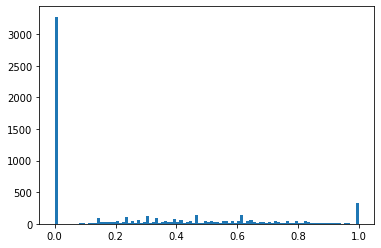

In [7]:
plt.hist(dcgs, bins=100)